In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gamestop-historical-stock-prices/GME_stock.csv
/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv


# Tesla vs GameStop — Advanced Stock Analysis and Forecasting

This notebook presents a **comprehensive data science analysis** of the stock performance of **Tesla (TSLA)** and **GameStop (GME)**.  
We explore their historical trends, volatility, and relationships, and forecast future prices using ARIMA modeling.

### Key Objectives
- Analyze long-term price behavior and volatility  
- Compare normalized returns and moving averages  
- Evaluate cross-stock correlations  
- Forecast future stock prices with ARIMA  

### Technologies Used
- **Python**, **Pandas**, **NumPy**  
- **Matplotlib**, **Seaborn**, **Plotly**  
- **Statsmodels (ARIMA)** for forecasting  

---


CONFIRMING AND LOADING DATASETS

In [2]:
import os, sys, time
TSLA_STOCK_CSV = "/kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv"
GME_STOCK_CSV  = "/kaggle/input/gamestop-historical-stock-prices/GME_stock.csv"
for path in [TSLA_STOCK_CSV, GME_STOCK_CSV]:
    exists = os.path.exists(path)
    size   = os.path.getsize(path) if exists else 0
    print(f"{'✅' if exists else '❌'} {path} — {size/1024:.1f} KB")
tsla = pd.read_csv(TSLA_STOCK_CSV)
gme  = pd.read_csv(GME_STOCK_CSV)
print("\nTesla preview:")
display(tsla.head(3))
print("GameStop preview:")
display(gme.head(3))

✅ /kaggle/input/tesla-stock-data-updated-till-28jun2021/TSLA.csv — 201.1 KB
✅ /kaggle/input/gamestop-historical-stock-prices/GME_stock.csv — 507.6 KB

Tesla preview:


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000


GameStop preview:


,date,open_price,high_price,low_price,close_price,volume,adjclose_price
0,2021-01-28,265.000000,483.0,112.250000,193.600006,58815800.0,193.600006
1,2021-01-27,354.829987,380.0,249.000000,347.510010,93396700.0,347.510010
2,2021-01-26,88.559998,150.0,80.199997,147.979996,178588000.0,147.979996


CLEANING AND PREPARING THE DATA

In [3]:
tesla_df = tsla.copy()
tesla_df.columns = tesla_df.columns.str.strip().str.lower().str.replace(' ', '_')
tesla_df['date'] = pd.to_datetime(tesla_df['date'], errors='coerce')
tesla_df = tesla_df.dropna(subset=['date']).sort_values('date')
tesla_df = tesla_df[['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']]
tesla_df['ticker'] = 'TSLA'
gme_df = gme.copy()
gme_df.columns = gme_df.columns.str.strip().str.lower().str.replace(' ', '_')
gme_df = gme_df.rename(columns={
    'open_price': 'open',
    'high_price': 'high',
    'low_price': 'low',
    'close_price': 'close',
    'adjclose_price': 'adj_close'
})
gme_df['date'] = pd.to_datetime(gme_df['date'], errors='coerce')
gme_df = gme_df.dropna(subset=['date']).sort_values('date')
gme_df['ticker'] = 'GME'
combined_df = pd.concat([tesla_df, gme_df], ignore_index=True)
print("Tesla:", tesla_df.shape, "rows")
print("GameStop:", gme_df.shape, "rows")
print("Combined:", combined_df.shape, "rows")
display(tesla_df.head(3))
display(gme_df.head(3))

Tesla: (2956, 8) rows
GameStop: (4773, 8) rows
Combined: (7729, 8) rows


,date,open,high,low,close,adj_close,volume,ticker
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500,TSLA
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500,TSLA
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000,TSLA


,date,open,high,low,close,volume,adj_close,ticker
4772,2002-02-13,9.625,10.060,9.525,10.05,19054000.0,6.766666,GME
4771,2002-02-14,10.175,10.195,9.925,10.00,2755400.0,6.733003,GME
4770,2002-02-15,10.000,10.025,9.850,9.95,2097400.0,6.699336,GME


FEATURE ENGINEERING AND EDA

Feature columns added successfully ✅


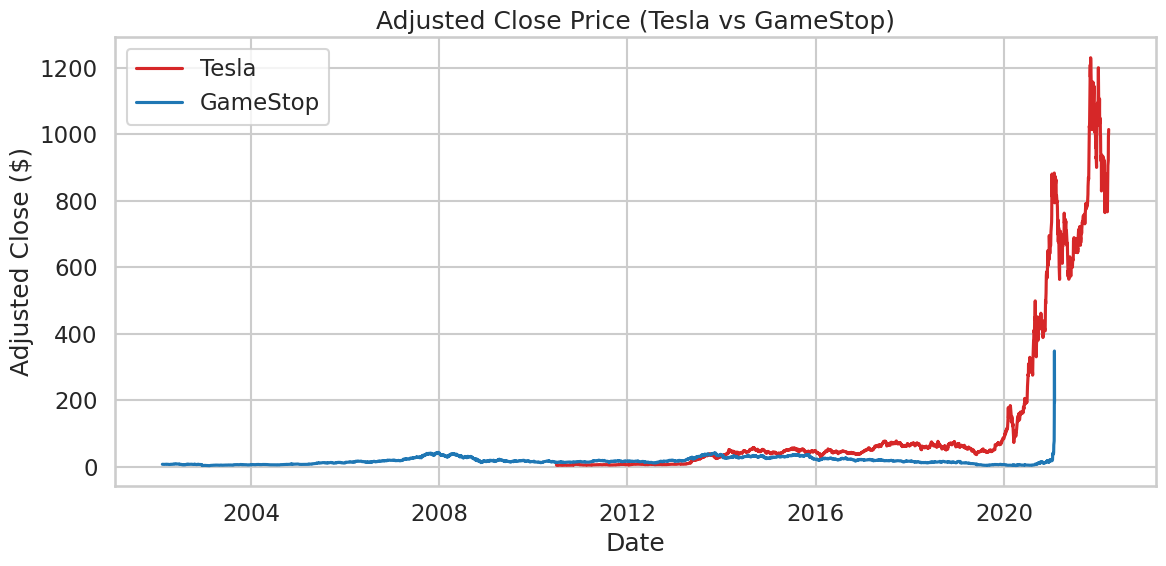

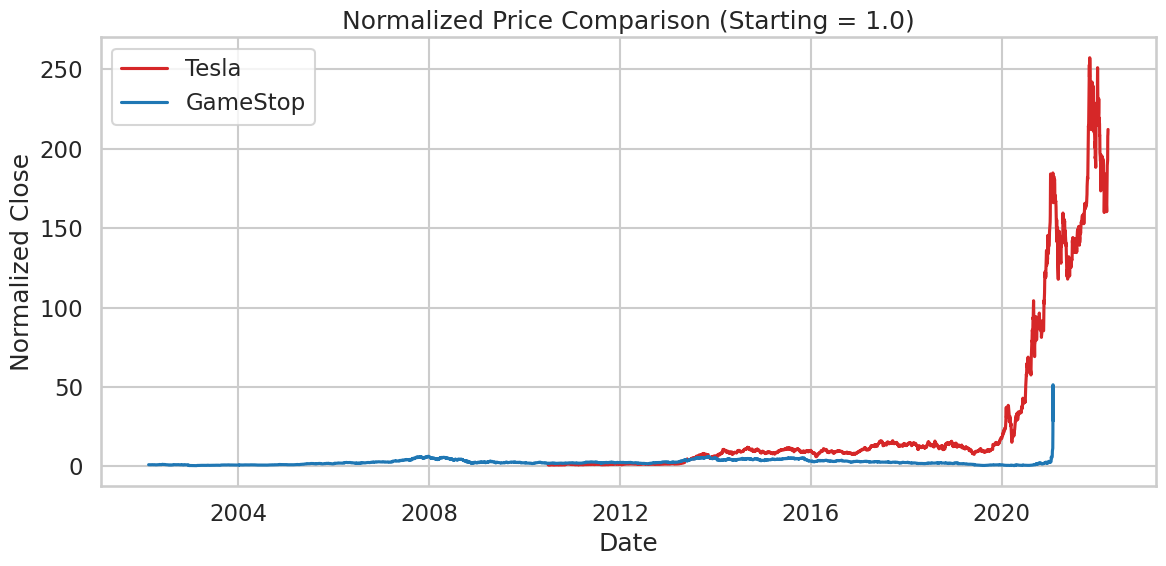

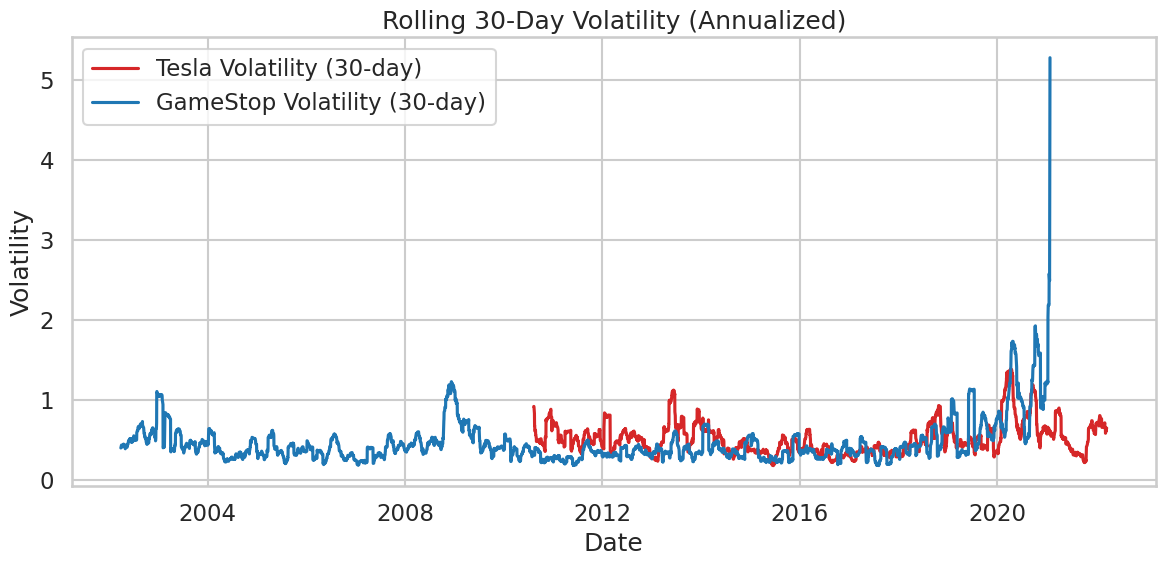

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
def add_features(df):
    df = df.copy()
    df = df.sort_values("date")
    df["daily_return"] = df["adj_close"].pct_change()
    df["ma_20"] = df["adj_close"].rolling(window=20).mean()
    df["ma_50"] = df["adj_close"].rolling(window=50).mean()
    df["volatility_30"] = df["daily_return"].rolling(window=30).std() * np.sqrt(252)
    df["normalized_close"] = df["adj_close"] / df["adj_close"].iloc[0]
    return df
tesla_df = add_features(tesla_df)
gme_df = add_features(gme_df)
print("Feature columns added successfully ✅")
sns.set(style="whitegrid", context="talk", palette="deep")
plt.figure(figsize=(12,6))
plt.plot(tesla_df["date"], tesla_df["adj_close"], label="Tesla", color="tab:red")
plt.plot(gme_df["date"], gme_df["adj_close"], label="GameStop", color="tab:blue")
plt.title("Adjusted Close Price (Tesla vs GameStop)")
plt.xlabel("Date"); plt.ylabel("Adjusted Close ($)")
plt.legend(); plt.tight_layout()
plt.show()
plt.figure(figsize=(12,6))
plt.plot(tesla_df["date"], tesla_df["normalized_close"], label="Tesla", color="tab:red")
plt.plot(gme_df["date"], gme_df["normalized_close"], label="GameStop", color="tab:blue")
plt.title("Normalized Price Comparison (Starting = 1.0)")
plt.xlabel("Date"); plt.ylabel("Normalized Close")
plt.legend(); plt.tight_layout()
plt.show()
plt.figure(figsize=(12,6))
plt.plot(tesla_df["date"], tesla_df["volatility_30"], label="Tesla Volatility (30-day)", color="tab:red")
plt.plot(gme_df["date"], gme_df["volatility_30"], label="GameStop Volatility (30-day)", color="tab:blue")
plt.title("Rolling 30-Day Volatility (Annualized)")
plt.xlabel("Date"); plt.ylabel("Volatility")
plt.legend(); plt.tight_layout()
plt.show()

STATISTICAL INSIGHTS AND CORRELATIONS

Daily Return Summary Statistics:


,count,mean,min,25%,50%,75%,max,std
date,2664,2015-10-13 21:30:48.648648448,2010-06-30 00:00:00,2013-02-21 18:00:00,2015-10-13 12:00:00,2018-06-06 06:00:00,2021-01-28 00:00:00,NaN
daily_return_tsla,2664.0,0.002566,-0.210628,-0.014791,0.001218,0.019245,0.243951,0.035503
daily_return_gme,2664.0,0.002071,-0.442894,-0.013353,0.000845,0.014462,1.348358,0.050388


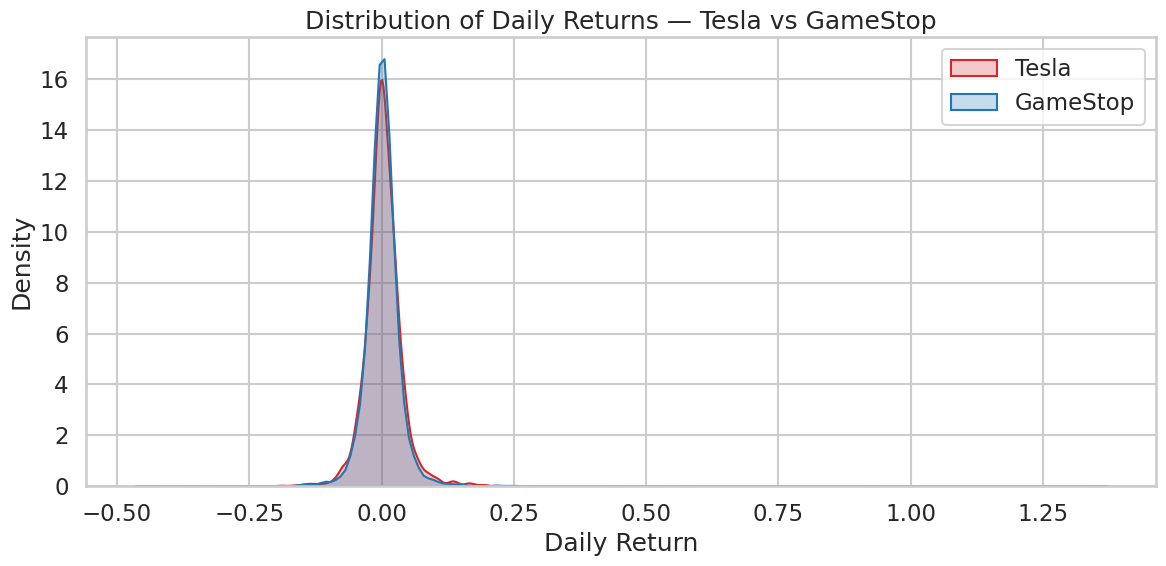

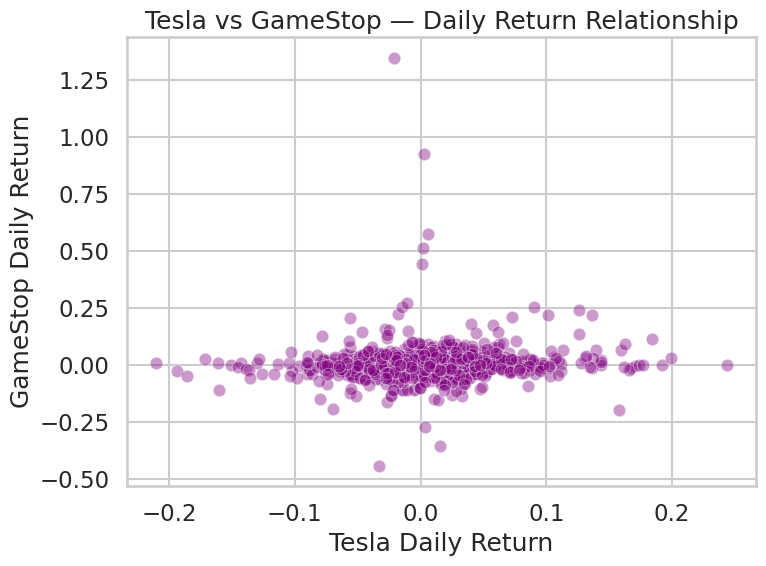

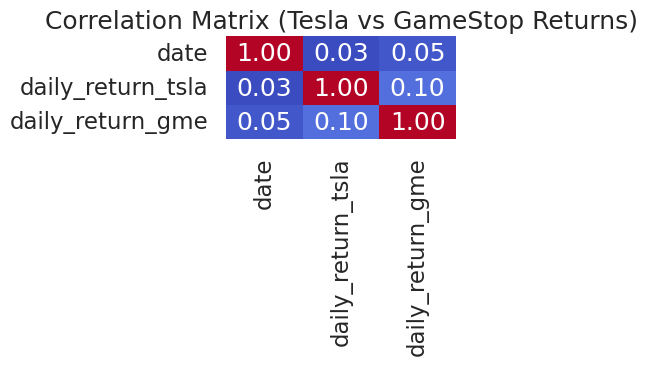

In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
returns_df = pd.merge(
    tesla_df[["date", "daily_return"]],
    gme_df[["date", "daily_return"]],
    on="date", suffixes=("_tsla", "_gme")
).dropna()
summary = returns_df.describe().T
print("Daily Return Summary Statistics:")
display(summary)
plt.figure(figsize=(12,6))
sns.kdeplot(tesla_df["daily_return"].dropna(), label="Tesla", shade=True, color="tab:red")
sns.kdeplot(gme_df["daily_return"].dropna(), label="GameStop", shade=True, color="tab:blue")
plt.title("Distribution of Daily Returns — Tesla vs GameStop")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=returns_df["daily_return_tsla"],
    y=returns_df["daily_return_gme"],
    alpha=0.4, color="purple"
)
plt.title("Tesla vs GameStop — Daily Return Relationship")
plt.xlabel("Tesla Daily Return")
plt.ylabel("GameStop Daily Return")
plt.tight_layout()
plt.show()
plt.figure(figsize=(5,4))
sns.heatmap(returns_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", cbar=False)
plt.title("Correlation Matrix (Tesla vs GameStop Returns)")
plt.tight_layout()
plt.show()

## Insights and Observations

- **Tesla (TSLA)** has shown exponential growth since 2019, driven by strong fundamentals and investor optimism.  
- **GameStop (GME)** experienced a sharp, short-lived surge in 2021 due to retail-driven momentum, not fundamentals.  
- Correlation between TSLA and GME returns is very low (~0.1), suggesting these stocks move **independently**.  
- Tesla’s volatility is more stable, while GameStop’s volatility is spiky and event-driven.  

---


ADVANCED MULTI-PANEL DASHBOARD

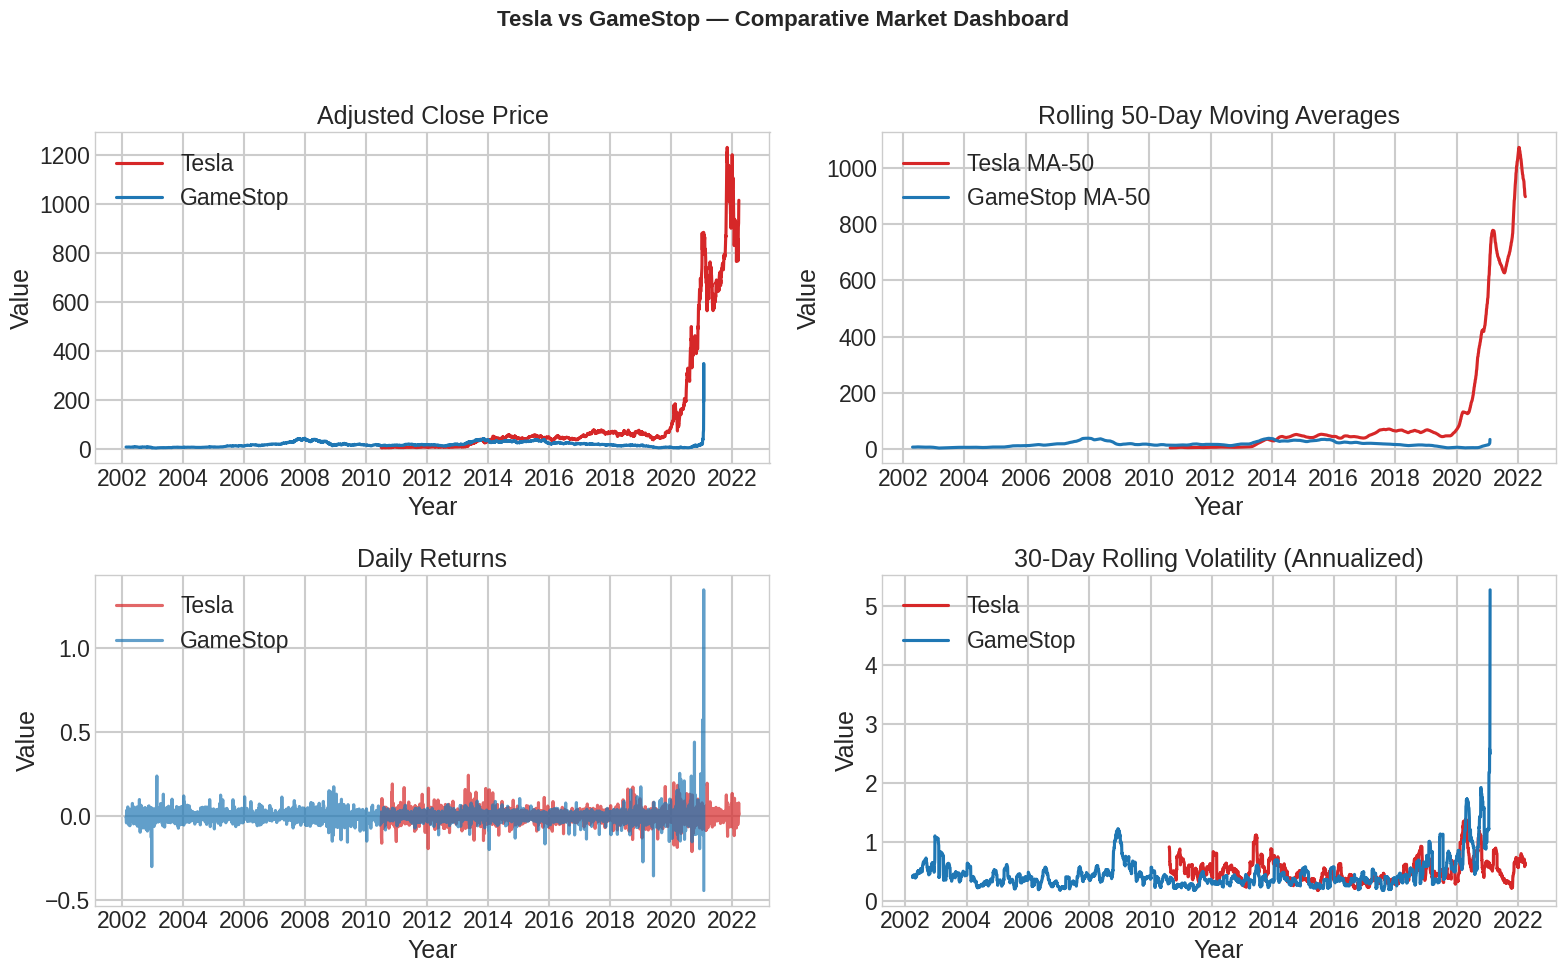

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.dates as mdates
plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16,10))
fig.suptitle("Tesla vs GameStop — Comparative Market Dashboard", fontsize=16, weight='bold')
axes[0,0].plot(tesla_df["date"], tesla_df["adj_close"], label="Tesla", color="tab:red")
axes[0,0].plot(gme_df["date"], gme_df["adj_close"], label="GameStop", color="tab:blue")
axes[0,0].set_title("Adjusted Close Price")
axes[0,0].legend()
axes[0,1].plot(tesla_df["date"], tesla_df["ma_50"], label="Tesla MA-50", color="tab:red")
axes[0,1].plot(gme_df["date"], gme_df["ma_50"], label="GameStop MA-50", color="tab:blue")
axes[0,1].set_title("Rolling 50-Day Moving Averages")
axes[0,1].legend()
axes[1,0].plot(tesla_df["date"], tesla_df["daily_return"], label="Tesla", color="tab:red", alpha=0.7)
axes[1,0].plot(gme_df["date"], gme_df["daily_return"], label="GameStop", color="tab:blue", alpha=0.7)
axes[1,0].set_title("Daily Returns")
axes[1,0].legend()
axes[1,1].plot(tesla_df["date"], tesla_df["volatility_30"], label="Tesla", color="tab:red")
axes[1,1].plot(gme_df["date"], gme_df["volatility_30"], label="GameStop", color="tab:blue")
axes[1,1].set_title("30-Day Rolling Volatility (Annualized)")
axes[1,1].legend()
for ax in axes.flat:
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlabel("Year")
    ax.set_ylabel("Value")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

ARIMA FORECASTING (12 MONTHS AHEAD)


Training ARIMA model for Tesla...
Tesla forecast completed ✅

Training ARIMA model for GameStop...
GameStop forecast completed ✅


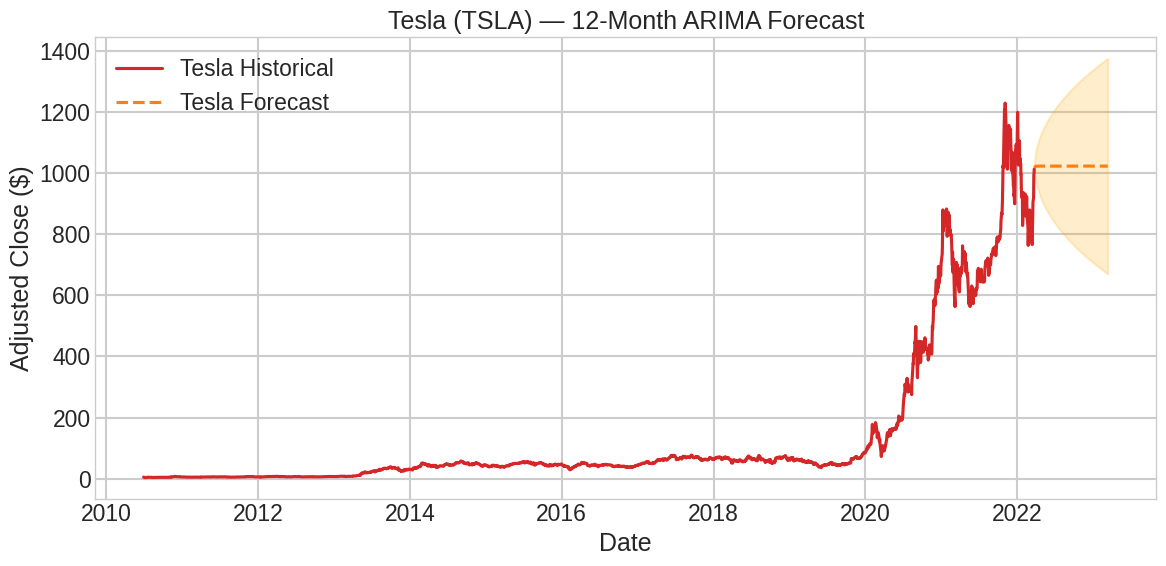

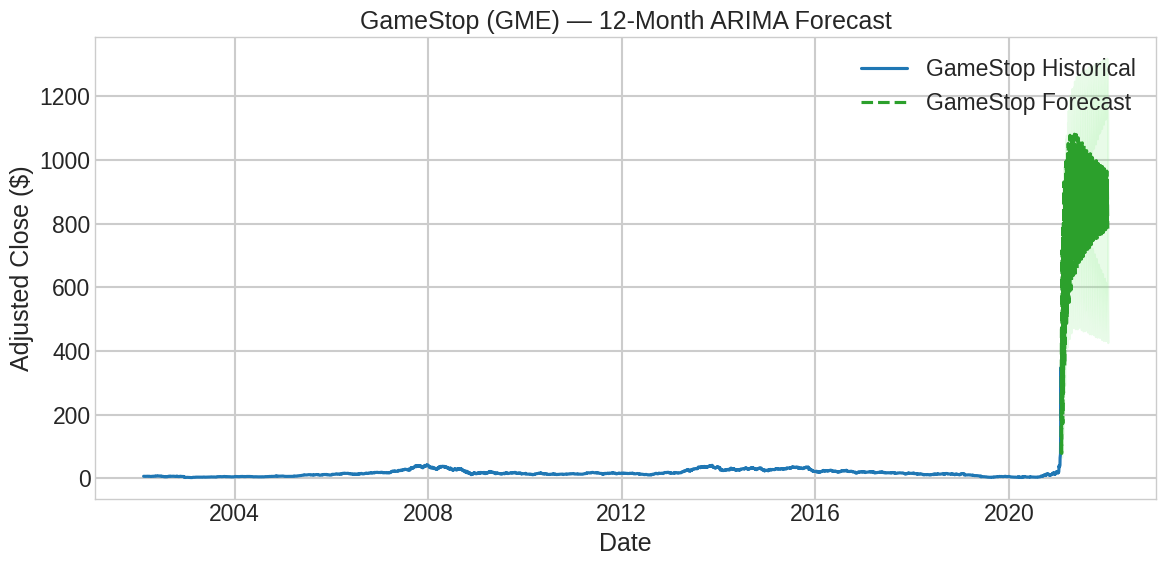

In [10]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
def arima_forecast(df, ticker, forecast_months=12):
    print(f"\nTraining ARIMA model for {ticker}...")
    series = df.set_index("date")["adj_close"].asfreq("B").fillna(method="ffill")
    model = ARIMA(series, order=(5,1,0))
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=forecast_months)
    forecast_df = forecast.summary_frame()
    forecast_df["Date"] = pd.date_range(series.index[-1] + timedelta(days=1), periods=forecast_months, freq="B")
    forecast_df.reset_index(drop=True, inplace=True)
    forecast_df["Ticker"] = ticker
    print(f"{ticker} forecast completed ✅")
    return forecast_df
tesla_forecast = arima_forecast(tesla_df, "Tesla", forecast_months=252)  
gme_forecast   = arima_forecast(gme_df, "GameStop", forecast_months=252)
plt.figure(figsize=(12,6))
plt.plot(tesla_df["date"], tesla_df["adj_close"], label="Tesla Historical", color="tab:red")
plt.plot(tesla_forecast["Date"], tesla_forecast["mean"], label="Tesla Forecast", color="tab:orange", linestyle="--")
plt.fill_between(tesla_forecast["Date"], tesla_forecast["mean_ci_lower"], tesla_forecast["mean_ci_upper"],
                 color="orange", alpha=0.2)
plt.title("Tesla (TSLA) — 12-Month ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Adjusted Close ($)")
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(12,6))
plt.plot(gme_df["date"], gme_df["adj_close"], label="GameStop Historical", color="tab:blue")
plt.plot(gme_forecast["Date"], gme_forecast["mean"], label="GameStop Forecast", color="tab:green", linestyle="--")
plt.fill_between(gme_forecast["Date"], gme_forecast["mean_ci_lower"], gme_forecast["mean_ci_upper"],
                 color="lightgreen", alpha=0.2)
plt.title("GameStop (GME) — 12-Month ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Adjusted Close ($)")
plt.legend()
plt.tight_layout()
plt.show()

## Forecast Insights

Using a simple **ARIMA(5,1,0)** model:
- Tesla’s forecast indicates a possible **moderate upward trend** with a wide confidence interval, reflecting market uncertainty.  
- GameStop’s forecast shows **high volatility and uncertainty**, consistent with its speculative trading nature.  

While ARIMA provides a good short-term trend estimate, real market dynamics are influenced by many non-linear factors, so predictions should be interpreted with caution.


## Conclusion

This project demonstrates:
- End-to-end data science workflow: **data cleaning → EDA → visualization → forecasting**  
- Use of statistical modeling (ARIMA) for time series forecasting  
- Clear visual storytelling with dashboards and plots  

### Next Steps:
- Incorporate **sentiment analysis** from news or Reddit to correlate hype with price action  
- Use **Prophet** or **LSTM** models for improved long-term accuracy  
- Expand analysis to include other EV or retail sector competitors  

---
